# Analyzing load testing runs

This notebook demonstrates how to analyze **AI Platform Prediction** load testing runs using metrics captured in **Cloud Monitoring**. 

This notebook complements, the `03-perf-testing.ipynb` notebook that shows how to configure and run load tests against AI Platform Prediction using [Locust.io](https://locust.io/). The outlined testing process results in a Pandas dataframe that aggregates [the standard AI Platform Prediction metrics](https://cloud.google.com/monitoring/api/metrics_gcp#gcp-ml) with a set of custom, log-based metrics generated from log entries captured by the Locust testing script.

In this notebook, you use Pandas and Matplotlib to analyze and visualize test results.

In the `test_results` folder you will find results of three load testing runs that were designed to help analyze the impact of [TF Serving batching](https://github.com/tensorflow/serving/tree/master/tensorflow_serving/batching) on resource utilization, throughput and latency. It is important to note that the captured results don't represent an outcome of a thorough performance tuning exercise. They were created to support the demonstration of common analytical techniques .

The tests where run against the `serving_preprocess` signature of the `ResNet101` model developed in the `01-prepare-for-serving.ipynb` notebook and deployed using the AI Platform Prediction Custom Container feature and the TF Serving docker image as described in the `02-deploy-to-aipp.ipynb` notebook. 

Since the goal of the tests was to analyze the impact of the server side batching, the tests were configured with a small, single image payload. Without batching, each image is processed immediately after receiving, which can lead to a high utilization of compute resources at low throughput. This is a very inefficient and costly scenario, especially when serving with GPUs.

The model version used in the tests was configured as follows:

Parameter | Value
----------| -----
Machine type | n1-standard-8
GPU type | NVidia P4
GPU count | 1
Serving image | `tensorflow/serving:latest-gpu`
GPU Autoscaling | enabled



Each test was run following the same load generation pattern. Locust users were created using the [step load pattern](https://docs.locust.io/en/stable/running-locust-in-step-load-mode.html). A new set of users (8 users) was created every 4 minutes up to a total of 152 users. Each user generated a single image predict request with a random wait time between requests. The wait times were randomly picked from the 1s to 2s range.


In [1]:
import time
import datetime

import pandas as pd

import google.auth

from google.cloud import monitoring_v3
from google.cloud import logging_v2

from google.cloud.monitoring_v3.query import Query
from google.cloud.monitoring_v3.types import TimeInterval
from google.api_core.exceptions import GoogleAPICallError

import matplotlib.pyplot as plt

## Analyzing GPU utilization

In the context of our scenario the key concern is GPU utilization at various levels of throughput and latency. The primary metric exposed by AI Platform Prediction to monitor GPU utilization is `duty cycle`. This metric captures an average fraction of time over the 60 second period during which the accelerator(s) were actively processing.

### Load test results
The `test_results` folder contains three files.

In [2]:
!ls  test_results

README.md		test-2-2020-08-13.gzip
test-1-2020-08-13.gzip	test-3-2020-08-13.gzip


The files are pickled Pandas dataframes that contain aggregated AI Platform Prediction and Locust custom based metrics. The files were created using the process described in the `03-perf-testing.ipynb` notebook.

The `test-1-2020-08-13.gzip` contains results of testing a model version with batching disabled.

The `test-2-2020-08-13.gzip` contains results of testing a model version configured with the following batching parameters. Please refer to [the batching guide](https://github.com/tensorflow/serving/blob/master/tensorflow_serving/batching/README.md#batch-scheduling-parameters-and-tuning) for an in-depth discussion on batching configuration.

```
batch_timeout_micros = 100ms
max_batch_size = 128
max_enqueued_batches = 16
num_batch_threads = 8
```

The `test-3-2020-08-13.gzip` contains results of testing a model version configured with the following batching parameters. 

```
batch_timeout_micros = 150ms
max_batch_size = 128
max_enqueued_batches = 16
num_batch_threads = 8
```

In [3]:
test_no_batching = pd.read_pickle('test_results/test-1-2020-08-13.gzip')
test_batching_100 = pd.read_pickle('test_results/test-2-2020-08-13.gzip')
test_batching_150 = pd.read_pickle('test_results/test-3-2020-08-13.gzip')

test_no_batching.head()

metric                                          duty_cycle  \
replica_id          resnb3624f-noba3d1f86-5bf6966cdc-67qks   
signature                                                    
2020-08-13 17:30:00                                    NaN   
2020-08-13 17:31:00                                    NaN   
2020-08-13 17:32:00                                    NaN   
2020-08-13 17:33:00                                    NaN   
2020-08-13 17:34:00                                    NaN   

metric                                                      \
replica_id          resnb3624f-noba3d1f86-5bf6966cdc-kczfd   
signature                                                    
2020-08-13 17:30:00                                    NaN   
2020-08-13 17:31:00                                   0.00   
2020-08-13 17:32:00                                   0.00   
2020-08-13 17:33:00                                   0.09   
2020-08-13 17:34:00                                   0.09   

metric                                                      \
replica_id          resnb3624f-noba3d1f86-5bf6966cdc-mmv8v   
signature                                                    
2020-08-13 17:30:00                                    NaN   
2020-08-13 17:31:00                                    NaN   
2020-08-13 17:32:00                                    NaN   
2020-08-13 17:33:00                                    NaN   
2020-08-13 17:34:00                                    NaN   

metric                                     cpu_utilization  \
replica_id          resnb3624f-noba3d1f86-5bf6966cdc-67qks   
signature                                                    
2020-08-13 17:30:00                                    NaN   
2020-08-13 17:31:00                                    NaN   
2020-08-13 17:32:00                                    NaN   
2020-08-13 17:33:00                                    NaN   
2020-08-13 17:34:00                                    NaN   

metric                                                      \
replica_id          resnb3624f-noba3d1f86-5bf6966cdc-kczfd   
signature                                                    
2020-08-13 17:30:00                                    NaN   
2020-08-13 17:31:00                               0.017231   
2020-08-13 17:32:00                               0.019197   
2020-08-13 17:33:00                               0.073306   
2020-08-13 17:34:00                               0.127416   

metric                                                     prediction_count  \
replica_id          resnb3624f-noba3d1f86-5bf6966cdc-mmv8v                    
signature                                                                     
2020-08-13 17:30:00                                    NaN              0.0   
2020-08-13 17:31:00                                    NaN              0.0   
2020-08-13 17:32:00                                    NaN            139.0   
2020-08-13 17:33:00                                    NaN            340.0   
2020-08-13 17:34:00                                    NaN            286.0   

metric              response_rate Latency: api server Latency: model  \
replica_id                                                             
signature                                                              
2020-08-13 17:30:00           NaN                 0.0            0.0   
2020-08-13 17:31:00          0.00                 0.0            0.0   
2020-08-13 17:32:00          0.27                36.0          200.0   
2020-08-13 17:33:00          4.65                23.7           50.1   
2020-08-13 17:34:00          5.28                15.9           29.9   

metric              Latency: network Latency: overhead Latency: total  \
replica_id                                                              
signature                                                               
2020-08-13 17:30:00              0.0               0.0            0.0   
2020-08-13 17

The dataframes use hierarchical indexing for column names. The reason is that some metrics contain multiple time series. For example, the GPU duty_cycle metric includes a time series of measures per each GPU used (denoted as replica_id). The top level of the column index is a metric name. The second level is a replica_id. The third level is a signature of a model.


### Aligning timestamp indexes

Each dataframe has a `DataTimeIndex` with a granularity of 1 minute. To simplify comparisons between tests we will convert the indexes to zero based `TimedeltaIndex` indexes that represent time deltas from the beginning of a test.

In [4]:
for df in [test_no_batching, test_batching_100, test_batching_150]:
    df.set_index(df.index - df.index[0], inplace=True)

### GPU utilization with batching disabled

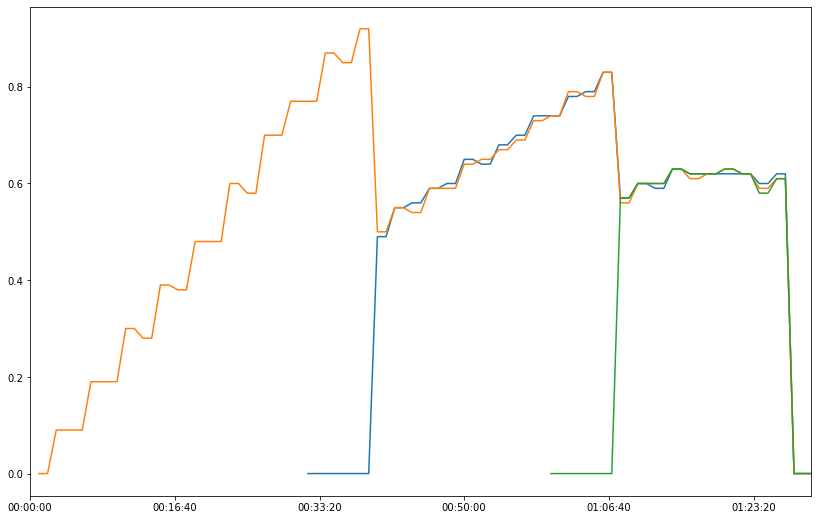

In [5]:
test_no_batching[('duty_cycle')].plot(figsize=(14, 9), legend=False)

The graph shows that as the load sent to the tested model version increases, the corresponding GPU utilization of the initally alocated GPU also increases. Around 30 minutes into test, the second GPU is allocated. This is a result of autoscaling. Soon after, the third GPU is allocated to handle the increasing load. 

Let's analyze it in more detail.

In [6]:
test_no_batching.loc['00:30:00' : '00:35:00'][('duty_cycle')]

replica_id,resnb3624f-noba3d1f86-5bf6966cdc-67qks,resnb3624f-noba3d1f86-5bf6966cdc-kczfd,resnb3624f-noba3d1f86-5bf6966cdc-mmv8v
signature,,,
00:30:00,NaN,0.77,NaN
00:31:00,NaN,0.77,NaN
00:32:00,0.0,0.77,NaN
00:33:00,0.0,0.77,NaN
00:34:00,0.0,0.87,NaN
00:35:00,0.0,0.87,NaN


By default, the AI Platform Prediction autoscaling process starts allocating a new GPU when the average utilization across existing GPUs is sustained at over 60%. This is a configurable threshold. In the tested model deployment the default configuration was used. 

You can see that the new GPU did not go live until around 32 minutes into the test when the utilization of the active GPU reached around 77% utilization. The traffic was switched by the autoscaler at around 92%. 

The autoscaling process was triggered again a few minutes later. 

After the maximum number of load clients (152) was reached, the average utilization across all three allocated GPUs leveled at around 60%.

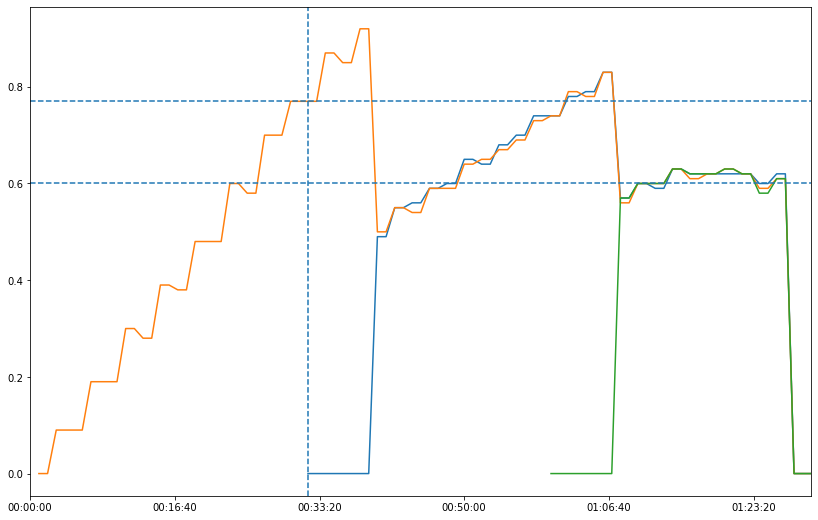

In [7]:
ax = test_no_batching[('duty_cycle')].plot(figsize=(14, 9), legend=False)
ax.axvline(pd.Timedelta(32, unit='min')/pd.Timedelta(1, unit='ns'), linestyle='--')
ax.axhline(0.77, linestyle='--')
ax.axhline(0.60, linestyle='--')

Let's now look at the CPU utilization.

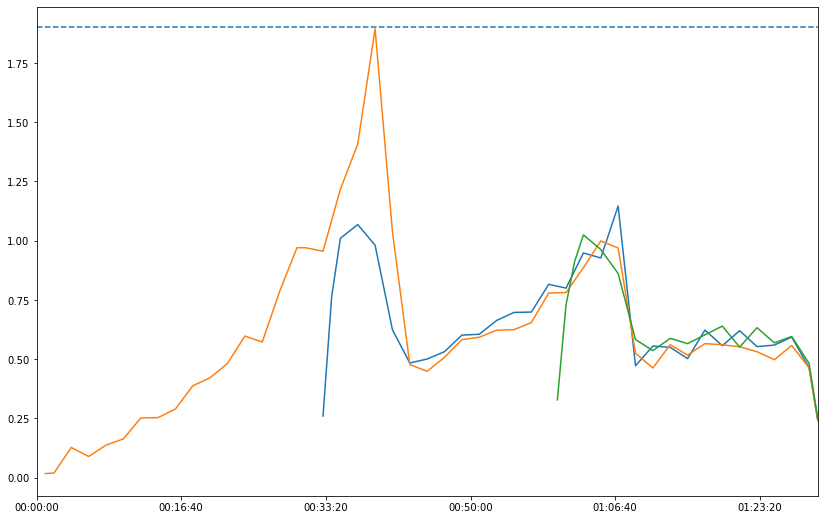

In [8]:
ax = test_no_batching[('cpu_utilization')].plot(figsize=(14, 9), legend=False)
ax.axhline(1.9, linestyle='--')

You can see a CPU utilization pattern similar to the GPU one. However, the overall CPU utilization remains low. Recall that the tested model is hosted on the `n1-standard-8` machine that has 8 CPU cores. The CPU utilization value of around 190% - the maximum on the chart - means that a maximum per core utilization is around 24%.

The CPU utilization remains low as most of the model's graph executes on a GPU. 

The following sections of the notebook will focus on GPU analysis.

### GPU utilization with batching enabled

We will now look at the GPU utilization with the TF Serving batching enabled.


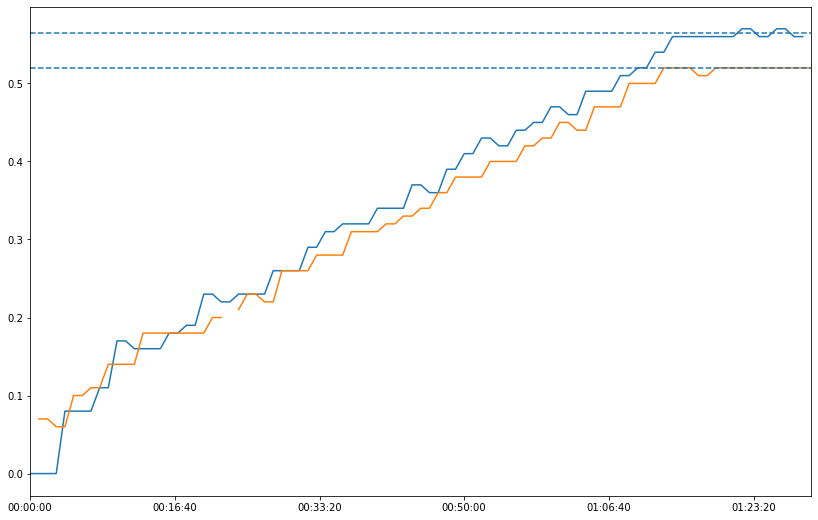

In [9]:
ax = test_batching_100[[('duty_cycle')]]\
.merge(test_batching_150[[('duty_cycle')]], how='outer', right_index=True, left_index=True)\
.plot(figsize=(14, 9), legend=False)
ax.axhline(0.565, linestyle='--')
ax.axhline(0.52, linestyle='--')

As you can see, in both tests the autoscaling was not triggered since GPU utilization remained below 60% throughout the tests. 

For the test configured with a 100ms batch timeout, the GPU utilization at 152 Locust users stablized around 56%. When the batch timeout was set to 150ms, the GPU utilization flattened at around 52%.

At first glance, these results indicate significant improvement in GPU utilization per given load rate; however they need to be interpreted in the context of two other metrics - request rate and response latency - to get the full picture.

### Impact of server batching on throughput and response latencies

#### Response times as observed by Locust

We will be comparing response latencies as observed by Locust workers - the metric retrieved from Cloud Monitoring as `Latency: client`. This is a log-based metric calculated from log entries captured in Cloud Logging while executing Locust scripts. It is important to understand how the metric is calculated to avoid misinterpretations. 
1. Every 5 seconds the Locust master logs a JSON log entry to Cloud Monitoring. The log entry includes a field that captures the 95th percentile of response times measured over a 10 second sliding window. 
2. Cloud Monitoring aggregates Locust log entries using a 1 minute tumbling window. The latency values from log entries (the 95th percentile of response times) are averaged within the window and tracked as `Latency: client`.

Notice that we are clipping the first few minutes from the time series to remove high latency outliers caused by slow responses while the serving container was warming up.

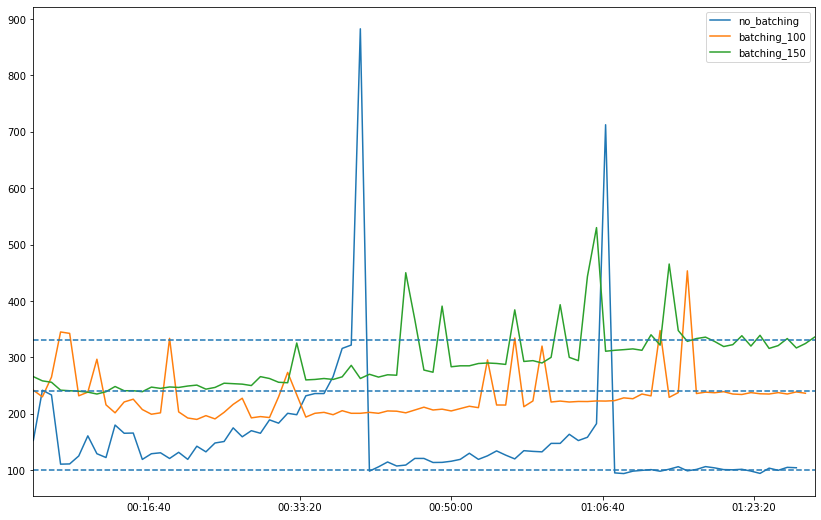

In [10]:
df = pd.concat([df[[('Latency: client')]] for df in [test_no_batching, test_batching_100, test_batching_150]], axis=1)
df.columns = pd.Index(['no_batching', 'batching_100', 'batching_150'])
ax = df.loc['00:04:00' : ].plot(figsize=(14, 9), legend=True)
ax.axhline(100, linestyle='--')
ax.axhline(240, linestyle='--')
ax.axhline(330, linestyle='--')

As expected, the configuration with no batching  has the lowest response times. The two high peaks observed on the plot are autoscaling events. When the autoscaler adds a new node the response times spike for a brief moment while the autscaler re-routes the traffic. The configuration with a 150ms batch timeout  has slightly higher response times than the configuration with 100ms.

After the maximum number of load clients has been reached, the response times stabilize at around 100ms, 240ms, and 330ms respectively.


 #### Request throughput
 
We are going to use the `response_rate` metric, which tracks a number of responses returned by AI Platform Prediction over a 1 minute interval.

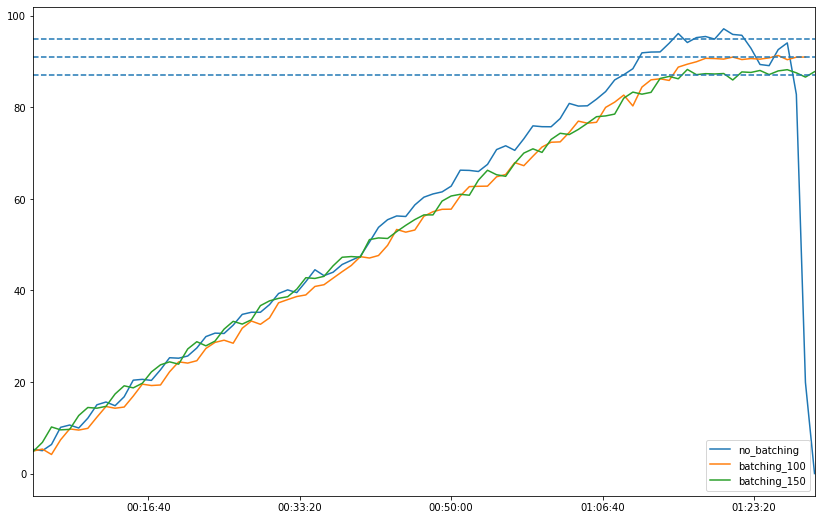

In [11]:
df = pd.concat([df[[('response_rate')]] for df in [test_no_batching, test_batching_100, test_batching_150]], axis=1)
df.columns = pd.Index(['no_batching', 'batching_100', 'batching_150'])
ax = df.loc['00:04:00' : ].plot(figsize=(14, 9), legend=True)
ax.axhline(91, linestyle='--')
ax.axhline(95, linestyle='--')
ax.axhline(87, linestyle='--')

When the maximum number of load clients is running, the throughput for all test configurations converges around 90 requests per second, with the no batching configuration on a higher end at around 95rps and the batching configuration with 150ms `batch_timeout_micros` at the lowest rate of around 87rps.

## Conclusions

Let's now bring all the numbers together. The following table summarizes the results of all tests at the maximum load level of 152 load clients.

Test | Response times | Request rate | GPU utilization (duty cycle)
-----|----------------|--------------|-----------------------------
No batching | ~100ms | ~95 rps | ~180% - three GPUs at 60% utilization
Batching enabled - 100ms batch timeout |  ~240ms|~91 rps  | ~56%
Batching enabled - 150ms batch timeout | ~330ms | ~87 rps | ~52%

The results demonstrate that in our test scenario - a small number of instances in each predict request and a relatively high number of concurrent clients - utilizing a server side batching can yield a significantfly better utilization of GPUs  at a manageable latency penalty. 

As the goal of this notebook was to demonstrate performance analysis techniques rather than performing a thorough optimization of TF Serving batching, even higher efficiences could be achieved with a more thorough testing regime.